# Analysing chemical data from bills of materials
Use this notebook to explain what SnyOracle is and does in a specific ordered fashion

In [1]:
%colors nocolor

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import seaborn as sns

try:
    from synoracle import ingredients
except ModuleNotFoundError:
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)
    from synoracle import ingredients

from tqdm.notebook import tqdm, trange

def li_iterate(li):
    l = iter(li)
    for _ in trange(len(li)):
        yield next(l)

In [3]:
with open('./processed_boms.json', 'r', encoding='utf-8') as f:
    rawdata = json.loads(f.read())

In [4]:
alldata = pd.DataFrame(columns=['pubchem_id','name', 'moles', 'synthesis_number'])
print(alldata)
for k,v in rawdata.items():
    placeholder = pd.DataFrame(eval(v)).reset_index().rename(columns={'index': 'pubchem_id'})
    placeholder['synthesis_number']=int(k)
    alldata = alldata.append(placeholder)

alldata['pubchem_id'] = alldata['pubchem_id'].astype(int)
display(alldata.head())

Empty DataFrame
Columns: [pubchem_id, name, moles, synthesis_number]
Index: []


,pubchem_id,name,moles,synthesis_number
0,702,[ethanol],0.000000,0
1,947,[nitrogen],0.000000,0
2,962,[H2O],1.101671,0
3,12749,[2-methylimidazole],0.002000,0
4,24821,[Co(NO3)2·6H2O],0.000500,0


In [5]:
def contains_element(pubchem_id: int, element_symbol: str) -> bool:
    entity = ingredients.ChemicalSpecies(alias=int(pubchem_id), property_cache_location='./cached_molecule_info.json')
    return element_symbol in entity.mol_formula

def substructure_compare(query_id, compare_id):
    from rdkit import Chem
    compare = ingredients.ChemicalSpecies(alias=int(compare_id), property_cache_location='./cached_molecule_info.json')
    query = ingredients.ChemicalSpecies(alias=int(query_id), property_cache_location='./cached_molecule_info.json')

    compare_chem = Chem.MolFromSmiles(compare.smiles)
    query_chem = Chem.MolFromSmiles(query.smiles)
    return query_chem.HasSubstructMatch(compare_chem)    

def contains_imidazole(pubchem_id: int) -> bool:
    return substructure_compare(pubchem_id, 795)

useful_ions = {
    'nitrate': 943,
    'sulfate': 1117,
    'acetate': 175,
    'chloride': 312,
    'oxide': 190217
}


In [6]:
with open('./chemical_typing_crossreference.json', 'r') as f:
    crossref = pd.DataFrame(json.load(f))
crossref.index = crossref.index.astype(int)

In [7]:
indices = list(alldata['pubchem_id'].unique())
for x in li_iterate(indices):
    try:
        if np.isnan(crossref.loc[x, 'contains_zinc']):
            print(x)
            for k,v in useful_ions.items():
                crossref.loc[x, f'contains_{k}'] = substructure_compare(x, v)
            crossref.loc[x, 'contains_imidazole'] = contains_imidazole(x)
            crossref.loc[x, 'contains_zinc'] = contains_element(x, 'Zn')
            crossref.loc[x, 'contains_cobalt'] = contains_element(x, 'Co')
    except KeyError:
        print(x)
        for k,v in useful_ions.items():
            crossref.loc[x, f'contains_{k}'] = substructure_compare(x, v)
        crossref.loc[x, 'contains_imidazole'] = contains_imidazole(x)
        crossref.loc[x, 'contains_zinc'] = contains_element(x, 'Zn')
        crossref.loc[x, 'contains_cobalt'] = contains_element(x, 'Co')

acids = [311, 313,612,944,  176, 243, 1004,1118, 1133,1152, 14917, 284, 
        1004, 6209, 6347, 7470, 7489, 8496, 11138, 25516, 25517, 
        71370, 517327, 3720192, 6097028]
bases = [1049,1146,129760994, 14797, 14798, 168937, 20586,
         222, 223,23675242, 24243, 243, 24436, 24540, 24654,3301, 5962,
        6115, 6224, 6341, 6503, 7497, 7504, 7618, 7852, 8007, 8102, 
        8111, 8471, 9033, 9237, 9321, 10005, 11107, 14923, 20586,
        24540, 168937, 517045, 2723810,23675242, 129760994 ]
amphoteric = [23663617, 283,943,961,1176, 14013]
surfactants = [5974, 8154, 14253, 2735067, 3423265, 5356789,
              5364713]
solvent_maps = [887, 962, 702, 6228, 6212, 1140, 174, 8028, 679, 8007, 6344, 8058, 3776, 5125, 12051]


crossref['contains_acid'] = crossref.index.isin([x for x in acids])
crossref['contains_base'] = crossref.index.isin([x for x in bases])
crossref['contains_amphoteric'] = crossref.index.isin([x for x in amphoteric])
crossref['contains_surfactant'] = crossref.index.isin([x for x in surfactants])
crossref['contains_solvent'] = crossref.index.isin([x for x in solvent_maps])


  0%|          | 0/407 [00:00<?, ?it/s]

In [8]:
crossref.head()

,contains_imidazole,contains_nitrate,contains_sulfate,contains_acetate,contains_chloride,contains_oxide,contains_zinc,contains_cobalt,contains_acid,contains_base,contains_amphoteric,contains_surfactant,contains_solvent
702,False,False,False,False,False,False,False,False,False,False,False,False,True
947,False,False,False,False,False,False,False,False,False,False,False,False,False
962,False,False,False,False,False,False,False,False,False,False,False,False,True
12749,True,False,False,False,False,False,False,False,False,False,False,False,False
24821,False,True,False,False,False,False,False,True,False,False,False,False,False


In [9]:
crossref.to_json('./chemical_typing_crossreference.json')

In [10]:

alldata = pd.merge(alldata, crossref, left_on='pubchem_id', right_index=True)

In [11]:
by_chemicals = alldata.groupby('pubchem_id').aggregate({
    'name': sum, 
    'moles': max,
    'synthesis_number': lambda x: len(list(x)),
    'contains_imidazole': np.all,
    'contains_zinc': np.all,
    'contains_nitrate': np.all,
    'contains_sulfate': np.all,
    'contains_acetate': np.all,
    'contains_chloride': np.all,
    'contains_oxide': np.all,
    'contains_cobalt': np.all

}).sort_values(by='synthesis_number', ascending=False)

### Acid/base statisics

,name,moles,synthesis_number,contains_imidazole,contains_zinc,contains_nitrate,contains_sulfate,contains_acetate,contains_chloride,contains_oxide,contains_cobalt
pubchem_id,,,,,,,,,,,
313,"[HCl, HCl, HCl, HCl, HCl, HCl, HCl, HCl, HCl, ...",3.000000,36,False,False,False,False,False,False,False,False
1118,"[H2SO4, H2SO4, H2SO4, H2SO4, H2SO4, sulfuric a...",2.354282,18,False,False,False,False,False,False,False,False
944,"[nitric acid, HNO3, HNO3, nitric acid, nitric ...",4.743942,9,False,False,False,False,False,False,False,False
176,"[acetic acid, acetic acid, Acetic acid, acetic...",0.017910,5,False,False,False,False,False,False,False,False
11138,"[BTC, 1,3,5-benzenetricarboxylic acid, H3BTC, ...",0.008000,5,False,False,False,False,False,False,False,False


c:\Users\d23895jm\Anaconda3\envs\SynOracle\lib\site-packages\ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator


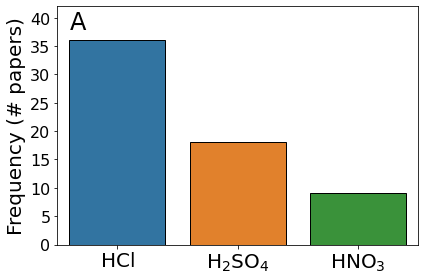

In [12]:
acids = [311, 313,612,944,  176, 243, 1004,1118, 1133,1152, 14917, 284, 
        1004, 6209, 6347, 7470, 8496, 11138, 25516, 25517, 
        71370, 517327, 3720192, 6097028] #7489
bases = [1049,1146,129760994, 14797, 14798, 168937, 20586,
         222, 223,23675242, 24243, 243, 24436, 24540, 24654,3301, 5962,
        6115, 6224, 6341, 6503, 7497, 7504, 7618, 7852, 8007, 8102, 
        8111, 8471, 9033, 9237, 9321, 10005, 11107, 14923, 20586,1176, 
        24540, 168937, 517045, 2723810,23675242, 129760994 ]
amphoteric = [23663617, 283,943,961, 14013]
surfactants = [5974, 8154, 14253, 2735067, 3423265, 5356789,
              5364713]

chemical_name_lookup = {
    313: '$\mathrm{HCl}$',
    1118: '$\mathrm{H_2SO_4}$',
    7489: '$\mathrm{H_2BTC}',
    944: '$\mathrm{HNO_3}$',
    2723810: '$\mathrm{HCOONa}$',
    14923: '$\mathrm{NH_4OH}$',
    8471: '$\mathrm{Et_3N}$',
    222: '$\mathrm{NH_3}$',
    14798: '$\mathrm{NaOH}$',
    8007: '$\mathrm{n-BuNH_2}$',
    9033: '$\mathrm{Azirane}$',
    1176: '$\mathrm{Urea}$',
    5974: '$\mathrm{CTAB}$',
    3423265: '$\mathrm{SDS}$'
}

fig, ax = plt.subplots()

display(by_chemicals[by_chemicals.index.isin([x for x in acids])].head())

data = by_chemicals[
    (by_chemicals.index.isin([x for x in acids])) &
    (by_chemicals['synthesis_number']>5)         
             ]['synthesis_number'].reset_index()

sns.barplot(data=data,
            x = 'pubchem_id',
            y = 'synthesis_number',
            ax=ax,
            order=[313,1118,944],
            edgecolor='k',
            linewidth=1,
            alpha=1
              )


labels = [chemical_name_lookup[int(z.get_text())] for z in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=0, fontsize=20)

ax.set_yticklabels([int(x) for x in ax.get_yticks()], fontsize=16)

ax.set_xlabel('')
ax.set_ylabel('Frequency (# papers)', fontsize=20)
ax.set_ylim([0,42])
ax.annotate('A', (-0.4, 38), fontsize=24)

plt.tight_layout()
plt.savefig('Fig 5a.png', dpi=900)

c:\Users\d23895jm\Anaconda3\envs\SynOracle\lib\site-packages\ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


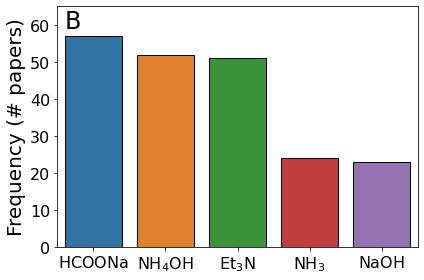

In [13]:
fig, ax = plt.subplots()

data = by_chemicals[
    (by_chemicals.index.isin([x for x in bases])) &
    (by_chemicals['synthesis_number']>5)         
             ]['synthesis_number'].reset_index()

sns.barplot(data=data,
            x = 'pubchem_id',
            y = 'synthesis_number',
            ax=ax,
            order = [2723810, 14923, 8471, 222, 14798],
            edgecolor='k',
            linewidth=1,
            alpha=1
)


labels = [chemical_name_lookup[int(z.get_text())] for z in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=0, fontsize=16)

ax.set_yticklabels([int(x) for x in ax.get_yticks()], fontsize=16)

ax.set_xlabel('')
ax.set_ylabel('Frequency (# papers)', fontsize=20)
ax.set_ylim([0,65])
ax.annotate('B', (-0.4, 59), fontsize=24)


plt.tight_layout()
plt.savefig('Fig 5b.png', dpi=900)

c:\Users\d23895jm\Anaconda3\envs\SynOracle\lib\site-packages\ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


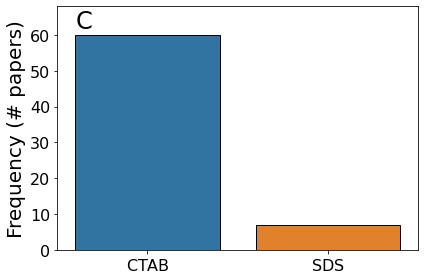

In [15]:
fig, ax = plt.subplots()

data = by_chemicals[
    (by_chemicals.index.isin([x for x in surfactants])) &
    (by_chemicals['synthesis_number']>5)         
             ]['synthesis_number'].reset_index()

sns.barplot(data=data,
            x = 'pubchem_id',
            y = 'synthesis_number',
            ax=ax,
            order = [5974, 3423265], 
            edgecolor='k',
            linewidth=1,
            alpha=1
)


labels = [chemical_name_lookup[int(z.get_text())] for z in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=0, fontsize=16)

ax.set_yticklabels([int(x) for x in ax.get_yticks()], fontsize=16)

ax.set_xlabel('')
ax.set_ylabel('Frequency (# papers)', fontsize=20)
ax.set_ylim([0,68])
ax.annotate('C', (-0.4, 62), fontsize=24)

plt.tight_layout()
plt.savefig('Fig 5c.png', dpi=900)